# Data from multiple trajectories
Generate learning data (Euler truncation errors) from several trajectories of the Van der Pol equation.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.integrate
import h5py

In [2]:
mu = 1.5
def vdp( t, x):
    y = np.empty(x.shape)
    y[0] = -mu*(x[1]*x[1]-1)*x[0]-x[1]
    y[1] = x[0]
    return y

range_x1 = [-5, -1, -0.5, 0, 0.5, 1, 5]
range_x0 = [-10, -5, -1, -0.5, 0, 0.5, 1, 5, 10]
t_all = np.empty(63000)
y_all = np.empty([63000, 2])
dydt_all = np.empty([63000, 2])
a = 0
for x1 in range_x1:
    for x0 in range_x0:
        if x0 == 0 and x1 == 0:
            continue
        end = 20
        t = np.random.rand(1000)*end
        t = np.sort(t)
        sol = scipy.integrate.solve_ivp(vdp, [0, end], [x0,x1], t_eval=t, rtol=1e-10, atol=1e-10)
        dydt = vdp(t, sol.y)
        t_all[a:a+1000] = t
        y_all[a:a+1000,:] = sol.y.T
        dydt_all[a:a+1000,:] = dydt.T
        a += 1000
print(y_all.shape)

(63000, 2)


## Plot

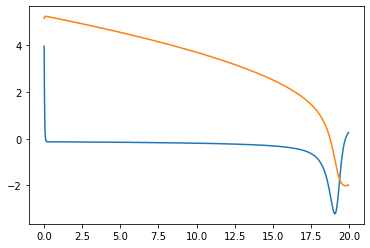

In [4]:
plt.figure(num="pl1")
plt.plot(sol.t,sol.y[0])
plt.plot(sol.t,sol.y[1])
plt.show()

## Save data

In [ ]:
if not os.path.isdir('data'):
    os.mkdir('data')
np.savetxt("data/vdp_data_iv.txt", np.column_stack((t_all, y_all, dydt_all)))

## Convert data and save in hdf5 format

In [ ]:
def euler_truncation_error(arr, output_size): 
    #t0 x1 x2 dx1 dx2
    dt = arr[1:,0] - arr[:-1,0]
    X = np.column_stack((arr[1:,0], arr[:-1,:1+output_size])) #t1 t0 x1(0) x2(0)
    dt_m = np.copy(dt)
    for n in range(1,output_size):
        dt_m = np.column_stack((dt_m,dt))
    Y = np.reciprocal(dt_m*dt_m)*(arr[1:,1:output_size+1] - arr[:-1,1:output_size+1] - dt_m*arr[:-1, output_size+1:])
    return X,Y

Generate the learning data from the simulation results. This may take some time. The printing runs until 62000.

In [ ]:
path_to_hdf = 'data/vdp_data_iv_dt.hdf5'
path_to_txt = 'data/vdp_data_iv.txt'
np.random.seed(410) #fix seed for reproducibility

arr = np.loadtxt(path_to_txt, dtype=np.float64, delimiter=' ')
print(arr.shape)
dt = True #whether to use absolute time or time steps
l = 1000
n = 1000
b = 0
sum = 0
for i in range(1,n):
    sum = sum + l - i - 1
print(sum)
sum = sum*9*7+1000

print(sum)
    
with h5py.File(path_to_hdf, 'a') as f:
    f.create_dataset(
        str('vdp_X'),
        (sum,3 if dt else 4),
        dtype   = np.float64,
        compression     = 'gzip',
        compression_opts= 8
        )
    f.create_dataset(
        str('vdp_Y'),
        (sum,2),
        dtype   = np.float64,
        compression     = 'gzip',
        compression_opts= 8
        )
    X = f['vdp_X']
    Y = f['vdp_Y']
    x_tmp = np.empty([498501,3])
    y_tmp = np.empty([498501,2])
    first = 0
    last = 0
    for u in range(9*7):
        print(u*1000)
        begin = 0
        end = 999
        x,y = euler_truncation_error(np.copy(arr[u*1000:(u+1)*1000][0::1]),2)
        if dt: 
            x = np.column_stack((x[:,0] - x[:,1],x[:,2],x[:,3]))
        x_tmp[begin:end,:] = x
        y_tmp[begin:end,:] = y
        for i in range(b+1,n):
            for j in range(i):
                x,y = euler_truncation_error(np.copy(arr[u*1000:(u+1)*1000][j::i]), 2)
                if dt: 
                    x = np.column_stack((x[:,0] - x[:,1],x[:,2],x[:,3]))
                begin = end
                end = begin+x.shape[0]
                x_tmp[begin:end,:] = x
                y_tmp[begin:end,:] = y
        mask = np.floor(np.random.random(498501)*6)==4 #random filtering of data
        length = np.count_nonzero(mask)
        last = first+length
        X[first:last,:] = x_tmp[mask,:]
        Y[first:last,:] = y_tmp[mask,:]
        first = last
        
    store_length = last
    print(store_length)

Check for all-zero lines at the end of the data array. These are unnecessary, remove all of them.

In [ ]:
with h5py.File(path_to_hdf, 'r+') as f:
    x = f["vdp_X"]
    y = f["vdp_Y"]
    print(x.shape)
    length = np.where(x[:,0] == 0.0)[0][0]
    x.resize((length, x.shape[1]))
    y.resize((length, y.shape[1]))
    print(x.shape)
    print(y.shape)